In [1]:
%matplotlib inline

In [2]:
import os
from matplotlib import pyplot as plt
import imutils
import cv2

plt.rcParams['figure.figsize'] = 20, 20

In [3]:
import mimetypes
from pathlib import Path

image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

def _get_files(parent, p, f, extensions):
    p = Path(p)  # .relative_to(parent)
    if isinstance(extensions, str):
        extensions = [extensions]
    low_extensions = [e.lower()
                      for e in extensions] if extensions is not None else None
    res = [p/o for o in f if not o.startswith('.')
           and (extensions is None or f'.{o.split(".")[-1].lower()}' in low_extensions)]
    return res


def get_files(path, extensions = None, recurse = False, exclude = None,
              include = None, presort = False, followlinks = False):
    "Return list of files in `path` that have a suffix in `extensions`; optionally `recurse`."
    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path, followlinks=followlinks)):
            # skip hidden dirs
            if include is not None and i == 0:
                d[:] = [o for o in d if o in include]
            elif exclude is not None and i == 0:
                d[:] = [o for o in d if o not in exclude]
            else:
                d[:] = [o for o in d if not o.startswith('.')]
                res += _get_files(path, p, f, extensions)
            if presort:
                res = sorted(
                    res, key=lambda p: _path_to_same_str(p), reverse=False)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, path, f, extensions)
        if presort:
            res = sorted(
                res, key=lambda p: _path_to_same_str(p), reverse=False)
        return res

In [4]:
def show(im, bw=False):
    plt.axis("off")
    if bw: plt.imshow(im, cmap='gray')
    else: plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

## Experimentation

In [192]:
num_photos = 3
path = f'My Scans/{str(num_photos)}/'
scans = get_files(path, extensions=image_extensions)

dest_dir = f'Crops/{str(num_photos)}'
os.makedirs(dest_dir, exist_ok=True)

In [206]:
im = path + '942.jpg'
image = cv2.imread(str(im))
border_size = 50
image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, None, (255, 255, 255))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)[1]
thresh = cv2.medianBlur(thresh, 21)

In [210]:
cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [208]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)

In [211]:
copy = image.copy()
ROI_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
#     if (w > (copy.shape[1] - 300)) and (h > (copy.shape[0] - 300)): 
#         print(w,h)
#         continue
    ROI = image[y:y+h, x:x+w]
#     cv2.imwrite(f'{im.stem}__{str(ROI_number)}.jpg', ROI)
    cv2.rectangle(copy,(x,y),(x+w,y+h),(255),10)
    ROI_number += 1
#     if ROI_number >= num_photos: break

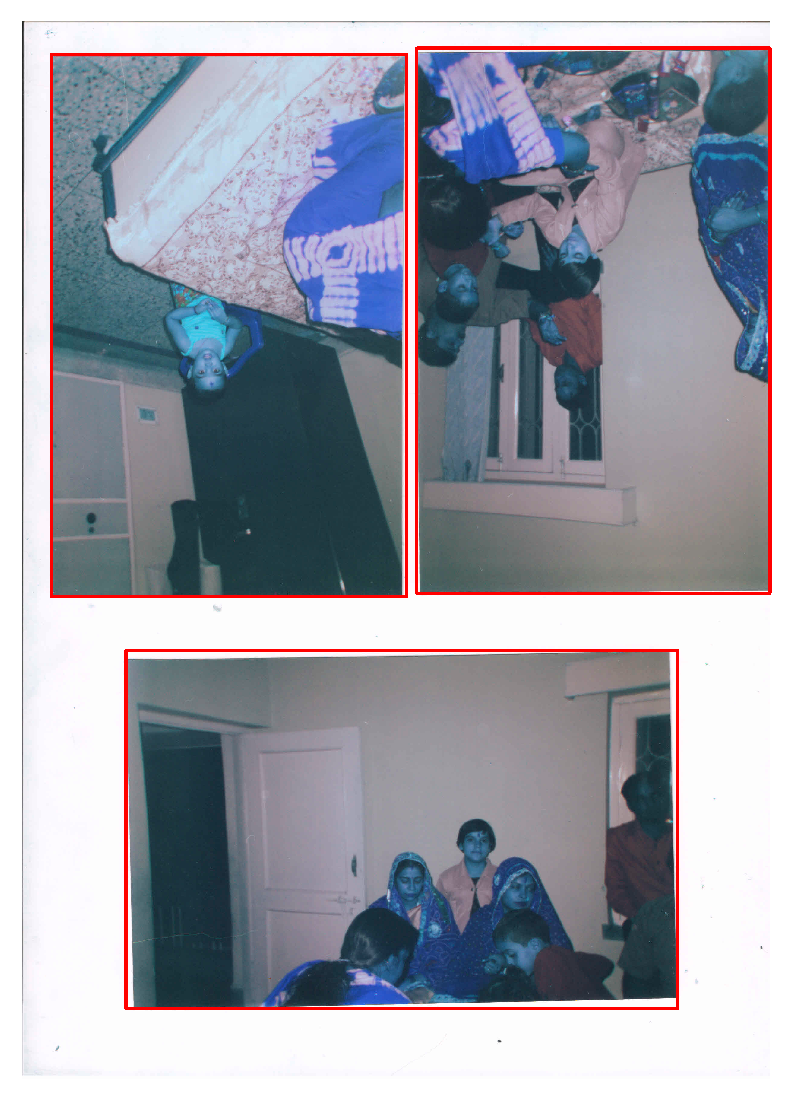

In [212]:
show(copy, True)

## Script

In [6]:
num_photos = 5
path = f'My Scans/{str(num_photos)}/'
scans = get_files(path, extensions=image_extensions)

dest_dir = f'Crops/{str(num_photos)}'
os.makedirs(dest_dir, exist_ok=True)

for im in scans:
    image = cv2.imread(str(im))
    border_size = 50
    image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, None, (255, 255, 255))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)[1]
    thresh = cv2.medianBlur(thresh, 21)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)
    
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    ROI_number = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if (w > image.shape[1] - 300) and (h > image.shape[0] - 300): continue
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite(f'{dest_dir}/{im.stem}__{str(ROI_number)}.jpg', ROI)
        ROI_number += 1
        if ROI_number >= num_photos: break

In [187]:
len(scans)

73